<a href="https://colab.research.google.com/github/rajuzumaki2207/Classification_Problems/blob/main/Ensemble_XG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Context
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]

Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

Customers who left within the last month – the column is called Churn
Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers – gender, age range, and if they have partners and dependents
Inspiration
To explore this type of models and learn more about the subject.


**The “Churn” column is our target.**



New version from IBM:
https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113

In [4]:
## Read the data set
path = "/content/drive/MyDrive/ML/Projects/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df =pd.read_csv(path)

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df.drop("customerID", axis=1, inplace=True)

Total charges should be float.


In [8]:
df1 = df[df["TotalCharges"]!=" "] # Droping columns with blank total charges (One can immute as well or put 0)

In [9]:
len(df1[df1.TotalCharges == " "])

0

In [10]:
df1["TotalCharges"]= df1["TotalCharges"].apply(pd.to_numeric)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
df1.describe() ## Hooray we did it :)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [12]:
df1.SeniorCitizen.astype('category')

0       0
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: SeniorCitizen, Length: 7032, dtype: category
Categories (2, int64): [0, 1]

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)
plt.rcParams["figure.figsize"] = (20,10)

In [15]:
cont_col = df1.describe().columns ## Continous variable

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


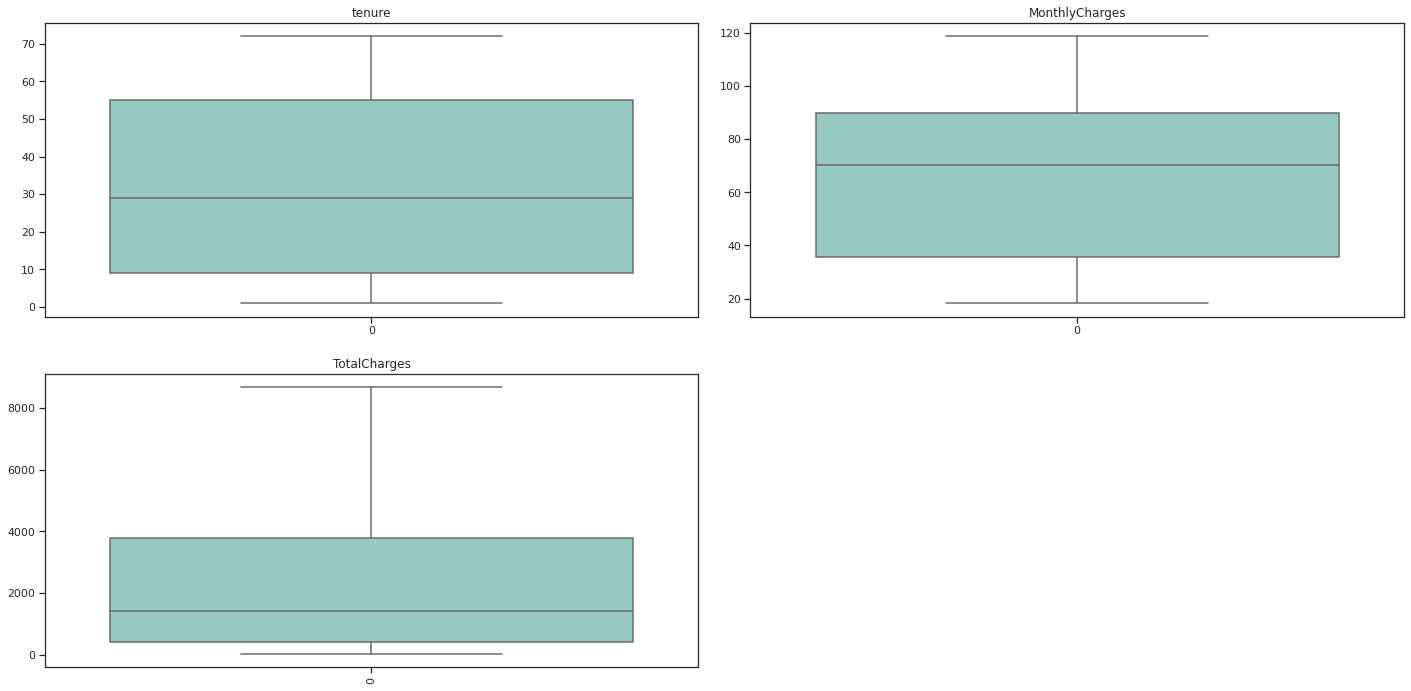

In [16]:
#box plot for cont_col
data=df1[cont_col]
data.drop("SeniorCitizen",axis= 1, inplace=True)
plt.rcParams.update({'font.size':20})
for i, col in enumerate(data):
  plt.subplot(2,2, i+1)
  
  sns.boxplot(data=data[col],palette = "Set3").set(title=col)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [17]:
cat_col = df1.describe(include=object).columns ## for categorical data

In [18]:
type(cat_col)

pandas.core.indexes.base.Index

In [19]:
data2 = df1[cat_col]
data2["SeniorCitizen"] = df1["SeniorCitizen"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
data2.columns

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn', 'SeniorCitizen'],
      dtype='object')

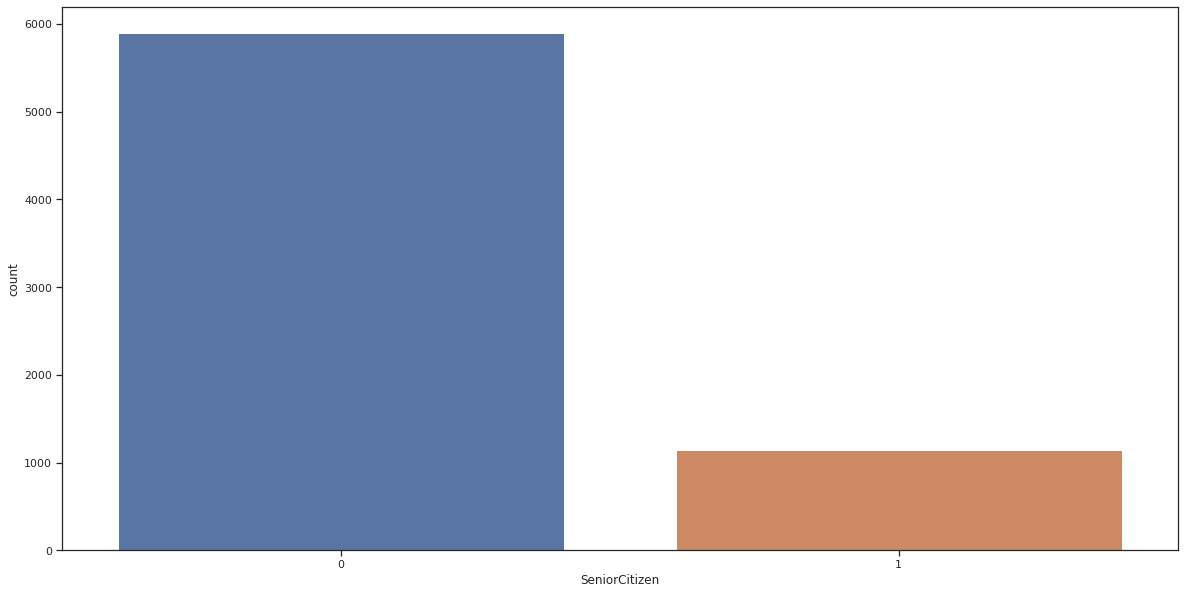

In [21]:
sns.countplot(x ='SeniorCitizen', data = df)

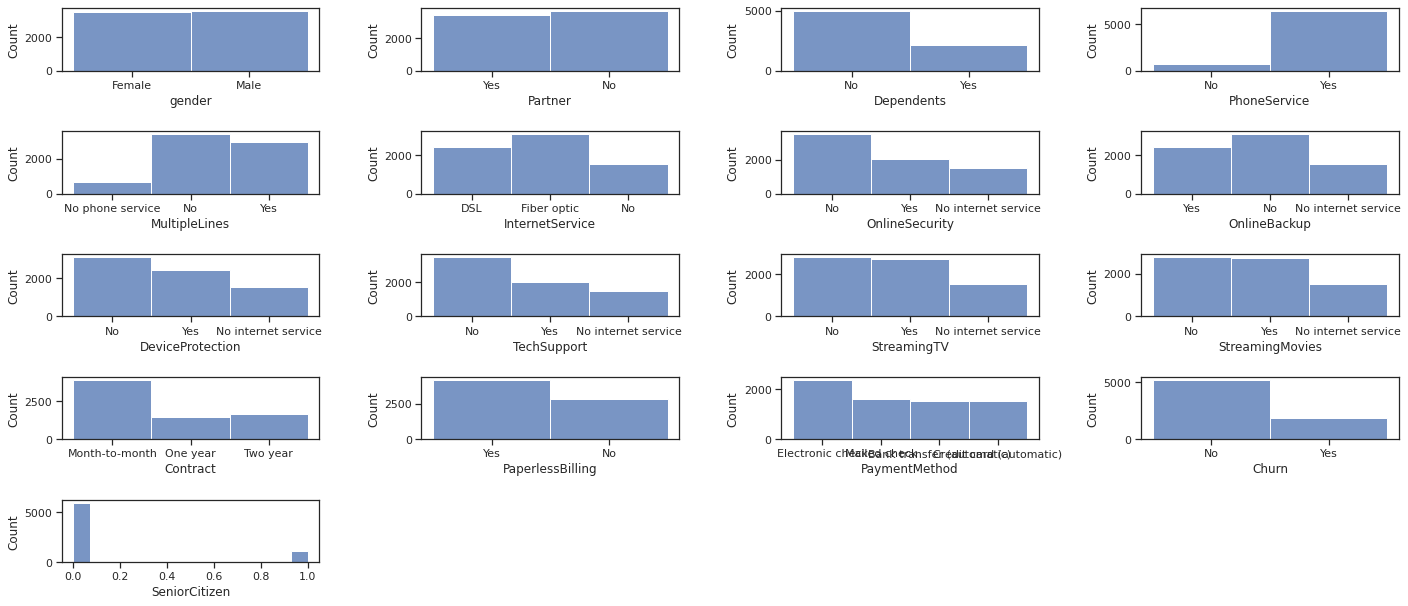

In [22]:
## histplot to visualize the feature space (Categorical dataspace)
for i, column in enumerate(data2.columns):
    plt.subplot(6,4, i+1)
    sns.histplot(data=data2[column])
plt.tight_layout()
plt.show()

In [23]:
df1["PaymentMethod"].unique() # Basic intution says payment method should not affect our output
# Lets remove that empty space. I would use XG classifier here, hence cleaning it up is a good idea

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [24]:
df1.replace(" ", "_", regex=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [25]:
df1["PaymentMethod"].unique()

array(['Electronic_check', 'Mailed_check', 'Bank_transfer_(automatic)',
       'Credit_card_(automatic)'], dtype=object)

In [26]:
from sklearn.preprocessing import LabelEncoder

In [27]:
labelencoder = LabelEncoder()


In [28]:
df1["Churn_value"] = labelencoder.fit_transform(df1["Churn"]) # Encode target variable

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
df1.drop("Churn", axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn_value
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1


## Lets have X(Predictor variables) and Y(Traget Variables) in seperate DF

In [31]:
X= df1.drop("Churn_value", axis=1).copy()

In [32]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65


In [33]:
y= df1["Churn_value"].copy()

In [34]:
y.unique()

array([0, 1])

In [35]:
X["SeniorCitizen"]= pd.Series(np.where(X.SeniorCitizen.values == 1, "Yes", "No"),
          X.index)

In [36]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,No,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
3,Male,No,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75
4,Female,No,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65


In [37]:
One_HOT_COl = X.describe(include=object).columns

## Get Dummies (One HOT)

In [38]:
X_encoded = pd.get_dummies(data=X,prefix_sep="_", columns= One_HOT_COl)

In [39]:
X_encoded.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,1,29.85,29.85,1,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,0,1,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,0,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,1,1,0,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


## Build a preliminary XGboost Model

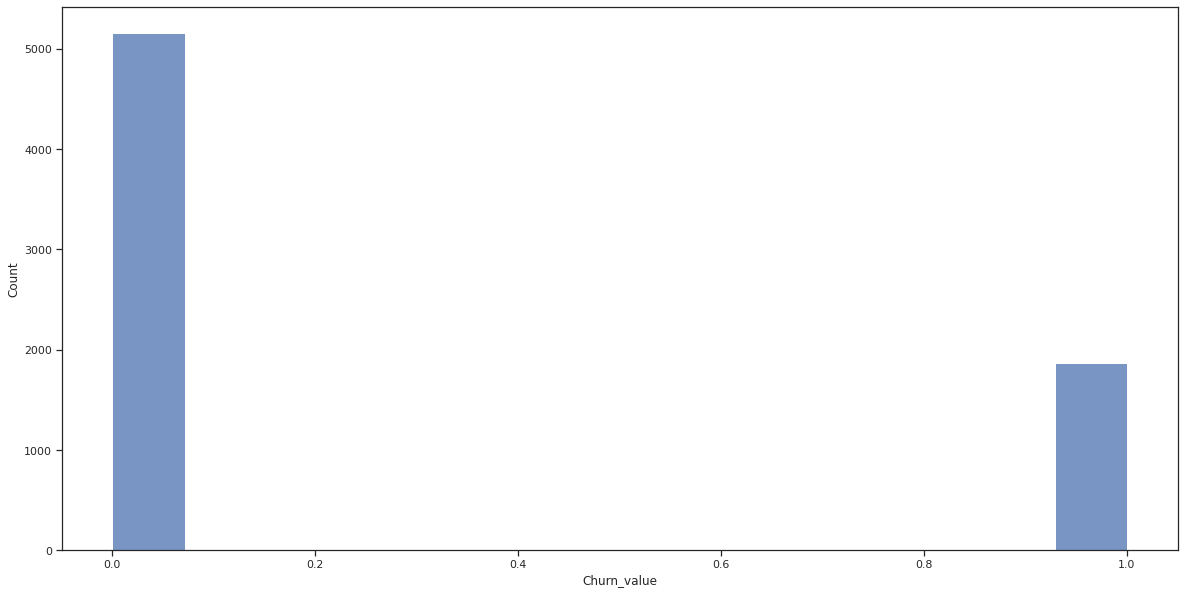

In [40]:
sns.histplot(data=y) ## As you can see Y values are heavily disbalanced

In [41]:
sum(y)/len(y) *100 

26.578498293515356

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y , random_state=42, stratify =y ) # We are statifying Y such that test train have similar Y data as original

In [44]:
X_train.shape

(5274, 46)

In [45]:
X_test.shape

(1758, 46)

In [46]:
sum(y_train)/len(y_train) # Stratifying worked

0.2658323852863102

In [47]:
sum(y_test)/len(y_test)

0.2656427758816837

In [48]:
from pandas.core.common import random_state
clf_XGB = xgb.XGBClassifier(objective="binary:logistic", seed=42)

In [49]:
clf_XGB.fit(X_train, y_train, 
            verbose=True,
            early_stopping_rounds=10,
            eval_metric="aucpr",
            eval_set= [(X_test, y_test)])

[0]	validation_0-aucpr:0.56444
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.570276
[2]	validation_0-aucpr:0.593737
[3]	validation_0-aucpr:0.595333
[4]	validation_0-aucpr:0.598776
[5]	validation_0-aucpr:0.596215
[6]	validation_0-aucpr:0.597173
[7]	validation_0-aucpr:0.62558
[8]	validation_0-aucpr:0.625487
[9]	validation_0-aucpr:0.626427
[10]	validation_0-aucpr:0.632234
[11]	validation_0-aucpr:0.633184
[12]	validation_0-aucpr:0.635384
[13]	validation_0-aucpr:0.641766
[14]	validation_0-aucpr:0.645125
[15]	validation_0-aucpr:0.645573
[16]	validation_0-aucpr:0.64711
[17]	validation_0-aucpr:0.647258
[18]	validation_0-aucpr:0.648837
[19]	validation_0-aucpr:0.648829
[20]	validation_0-aucpr:0.650257
[21]	validation_0-aucpr:0.651288
[22]	validation_0-aucpr:0.651982
[23]	validation_0-aucpr:0.651876
[24]	validation_0-aucpr:0.651356
[25]	validation_0-aucpr:0.652021
[26]	validation_0-aucpr:0.652761
[27]	validation_0-aucpr:0.653898
[28]	validation_0-aucpr

XGBClassifier(seed=42)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


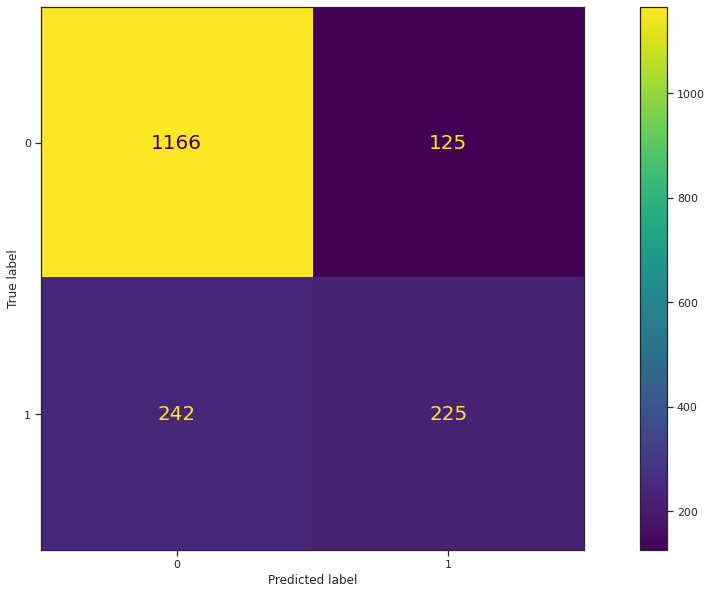

In [50]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_XGB, X_test, y_test)
plt.show()

**Clearly model is not able to predict people who left very accurately**

In [51]:
from sklearn.metrics import confusion_matrix

y_pred =clf_XGB.predict(X_test)

cm=confusion_matrix(y_test, y_pred)

In [52]:
tn, fp, fn, tp = cm.ravel()

In [53]:
print("True Postive : ", tp)
print("True Negative : ", tn)
print("False Postive :", fp)
print("False negative :", fn)

True Postive :  225
True Negative :  1166
False Postive : 125
False negative : 242


In [54]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='weighted')

0.780816925510367

In [75]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1291
           1       0.64      0.48      0.55       467

    accuracy                           0.79      1758
   macro avg       0.74      0.69      0.71      1758
weighted avg       0.78      0.79      0.78      1758



## Optimization using GridSearchCv and Cross-validation

In [61]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[3,4,5], 
              'learning_rate':[0.1 ,0.5, 0.75],
              "gamma": [0.25, 1.0],
              "min_child_weight":  [1,5],
              "reg_lambda": [0,1.0, 10.0,20.0],
              "scale_pos_weight": [1,3,5]}

In [62]:
optimal_params = GridSearchCV(
    estimator= xgb.XGBClassifier(objective = "binary:logistic",
                                seed=42,
                                 subsample=0.9,
                                 colsample_bytree=0.5),
                              param_grid=parameters ,
                              scoring = "roc_auc",
                              verbose=1,
                              n_jobs=10,
                              cv=5
)

In [63]:
optimal_params

GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.5, seed=42,
                                     subsample=0.9),
             n_jobs=10,
             param_grid={'gamma': [0.25, 1.0],
                         'learning_rate': [0.1, 0.5, 0.75],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 5],
                         'reg_lambda': [0, 1.0, 10.0, 20.0],
                         'scale_pos_weight': [1, 3, 5]},
             scoring='roc_auc', verbose=1)

In [64]:
optimal_params.fit(X_train, y_train) # Run only once, takes tooooooooo long

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.5, seed=42,
                                     subsample=0.9),
             n_jobs=10,
             param_grid={'gamma': [0.25, 1.0],
                         'learning_rate': [0.1, 0.5, 0.75],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 5],
                         'reg_lambda': [0, 1.0, 10.0, 20.0],
                         'scale_pos_weight': [1, 3, 5]},
             scoring='roc_auc', verbose=1)

In [65]:
print(optimal_params.best_params_)

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'reg_lambda': 20.0, 'scale_pos_weight': 1}


In [68]:
means=optimal_params.cv_results_["mean_test_score"]

In [69]:
stds = optimal_params.cv_results_["std_test_score"]

In [76]:
for mean, std, params in zip(means, stds, optimal_params.cv_results_["params"]):
  print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
 

0.849 (+/-0.017) for {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'reg_lambda': 0, 'scale_pos_weight': 1}
0.847 (+/-0.018) for {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'reg_lambda': 0, 'scale_pos_weight': 3}
0.845 (+/-0.018) for {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'reg_lambda': 0, 'scale_pos_weight': 5}
0.849 (+/-0.018) for {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'reg_lambda': 1.0, 'scale_pos_weight': 1}
0.848 (+/-0.019) for {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'reg_lambda': 1.0, 'scale_pos_weight': 3}
0.846 (+/-0.019) for {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'reg_lambda': 1.0, 'scale_pos_weight': 5}
0.850 (+/-0.018) for {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'reg_lambda': 10.0, 'scale_pos_weight': 1}
0.848 (+/-0.018) for {'ga

In [78]:
y_pred_op = optimal_params.predict(X_test)

In [79]:
print(metrics.classification_report(y_test, y_pred_op)) ## Not good, we are not able to classify customers who have left properly. Which is the target

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1291
           1       0.65      0.54      0.59       467

    accuracy                           0.80      1758
   macro avg       0.75      0.72      0.73      1758
weighted avg       0.79      0.80      0.80      1758



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


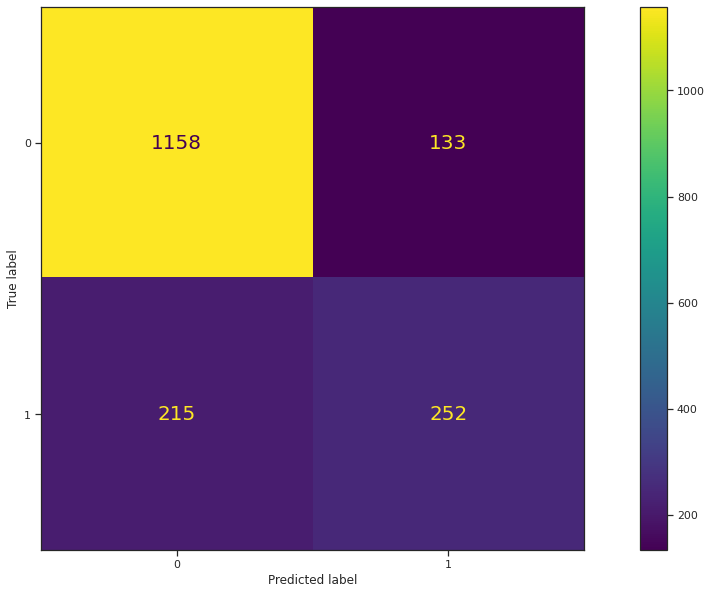

In [80]:
plot_confusion_matrix(optimal_params, X_test, y_test)
plt.show()